# FWP ROS - Maze Escape

TH Deggendorf - Campus Cham

Summer Semester 2023

Author: Felix Gatti

## 0. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy.signal as ss
import ipywidgets as widgets
import matplotlib.gridspec as gs
from ipywidgets import interact_manual
import os

## 1. Functions

In [2]:
def get_scan_window(position,maze,scan_size=20):
    '''Get surrounding area of current robot location'''
    
    x,y=position
    w,h = maze.shape
  
    pad_x = [max(0,scan_size-x),max(0,x-(w-scan_size))]
    pad_y = [max(0,scan_size-y),max(0,y-(h-scan_size))] 
    #print(pad_x,pad_y)

    x_min = max(x-scan_size,0)
    x_max = min(x+scan_size,w)
    y_min = max(y-scan_size,0)
    y_max = min(y+scan_size,h)
    
    area = maze[x_min:x_max,y_min:y_max]
    area = np.pad(area,(pad_x,pad_y),mode='constant',constant_values=255)
    
    return area

def get_index(r,alpha):
    '''Get image slice with lenght r at angle alpha'''
    
    r_step=np.arange(0,r,1)
    alpha=alpha*np.pi/180
    a = r_step*np.sin(alpha)
    b = r_step*np.cos(alpha)

    a=np.asarray(a,dtype='int32')+r
    b=np.asarray(b,dtype='int32')+r

    return a,b

def unroll_image_grayscale(img):
    '''Unroll image with 360 Degree resolution'''
    n,m = img.shape
    if n!=m:
        raise ValueError("Dimensions must be square...")
    
    r=int(n/2)
    flatten=[]
    for alpha in range(0,360,1):
        a,b = get_index(r,alpha)
        layer=[]
        for i in range(r):
         #   print(i)
            layer.append(img[a[i],b[i]])
        flatten.append(layer)
    unrolled=np.array(flatten)
    return unrolled

def get_position(scan):
    '''Find wall position in unrolled image to get distances'''
    distance = []
    for idx in range(scan.shape[0]):
        flank_down = np.where(scan[idx,:]==0)[0]
        try:
            flank_position=flank_down[0]
        except:
            flank_position = -1
        distance.append(flank_position)
    return np.array(distance)
   

def vis_scan(position,distances,maze):
    '''Visualize distances from scan in original maze'''
    y,x=position
    cv2.circle(maze,(x,y),radius = 1,color = (0,0,255),thickness=-1)
    for angle,dist in enumerate(distances):
        if dist != -1:
            dx,dy = int(dist*np.cos(angle*np.pi/180)),int(dist*np.sin(angle*np.pi/180))
            sx,sy = x+dx,y+dy
            cv2.circle(maze,(sx,sy),radius = 1,color = (int((255-(angle/360)*255)),0,int((angle/360)*255)),thickness=-1)
        



def scan_points(position,distances,maze):
    
    y,x=position
    lidar_scan = []
    for angle,dist in enumerate(distances):
        if dist != -1:
            dx,dy = int(dist*np.cos(angle*np.pi/180)),int(dist*np.sin(angle*np.pi/180))
            sx,sy = x+dx,y+dy
            lidar_scan.append([angle,dist,sx,sy])
        else:
            lidar_scan.append([angle,dist,x,y])
    return np.array(lidar_scan)  


def get_local_minima_v2(scan_dist,scan_range =30,include_max = False,safety_distance = 0):
    oor = np.where(scan_dist==-1)[0]
    if include_max:
        max_dist_idx = np.random.choice(np.where(scan_dist == np.max(scan_dist))[0])
        max_dist = np.max(scan_dist)-1 if np.max(scan_dist)>0 else scan_range-1
        max_dist = np.array([[max_dist_idx],[max_dist-safety_distance]]) 
    
    if oor.size!=0:

        indecies = np.where((oor[:-1]-oor[1:])!=-1)[0]
        if indecies.size!=0:
            slices=[]
            if (0 in oor) and (359 in oor): 
                #print('around 0')
                slices.append([oor[indecies[0]],oor[indecies[-1]+1]-360])
            else:
                slices.append([oor[0],oor[indecies[0]]])
                slices.append([oor[indecies[-1]+1],oor[-1]])

            for idx in range(indecies.size):

                if idx!=0:
                    slices.append([oor[indecies[idx-1]+1],oor[indecies[idx]]])
            
            slices = np.array(slices)
            
            pos_angles=np.mean(slices,axis=1).astype(np.int16)
        else:
            pos_angles = np.array([np.mean([oor[0],oor[-1]])])
        
        pos_angles = np.vstack((pos_angles,np.full((pos_angles.shape),(scan_range-1-safety_distance))))
            
    else:
        pos_angles = np.array([])
    
    if include_max:
        #print(pos_angles.shape,max_dist.shape)
        if pos_angles.size!=0:
            pos_angles = np.append(pos_angles,max_dist,axis=1)
        else:
            pos_angles = max_dist
        
    return pos_angles


def get_local_minima_v3(scan_dist,scan_range =30,include_max = True,include_oor = True,safety_distance = 0):
    oor = np.where(scan_dist==-1)[0]
    
    max_dist = np.array([[],[]])
    loc_max_dist = np.array([[],[]])
    oor_dist = np.array([[],[]])
    
    if include_max:
        max_dist_idx = np.random.choice(np.where(scan_dist == np.max(scan_dist))[0])
        max_dist = np.max(scan_dist)-1 if np.max(scan_dist)>0 else scan_range-1
        max_dist = np.array([[max_dist_idx],[max_dist-safety_distance]]) 
        
        loc_max_idx = ss.argrelextrema(scan_dist, np.greater)[0]
        
        loc_max_dist = scan_dist[loc_max_idx]-safety_distance
        loc_max_dist[loc_max_dist<=0] = scan_range-1
        loc_max_dist = np.vstack([loc_max_idx,loc_max_dist]) 
    
    if oor.size!=0 and include_oor:

        indecies = np.where((oor[:-1]-oor[1:])!=-1)[0]
        if indecies.size!=0:
            slices=[]
            if (0 in oor) and (359 in oor): 
                #print('around 0')
                slices.append([oor[indecies[0]],oor[indecies[-1]+1]-360])
            else:
                slices.append([oor[0],oor[indecies[0]]])
                slices.append([oor[indecies[-1]+1],oor[-1]])

            for idx in range(indecies.size):

                if idx!=0:
                    slices.append([oor[indecies[idx-1]+1],oor[indecies[idx]]])
            
            slices = np.array(slices)
            
            oor_dist=np.mean(slices,axis=1).astype(np.int16)
        else:
            oor_dist = np.array([np.mean([oor[0],oor[-1]])])
        
        oor_dist = np.vstack((oor_dist,np.full((oor_dist.shape),(scan_range-1-safety_distance))))
        
    pos_angles = np.concatenate([oor_dist,max_dist,loc_max_dist],axis=1)
        
    return pos_angles



def vis_pos_angles(position,maze,pos_angles,length=15):
    
    y,x=position
    cv2.circle(maze,(x,y),radius = 2,color = (0,0,255),thickness=-1)
    for idx,angle in enumerate(pos_angles):
        dx,dy = int(length*np.cos(angle*np.pi/180)),int(length*np.sin(angle*np.pi/180))
        sx,sy = x+dx,y+dy
        cv2.line(maze,(x,y),(sx,sy),color = (100,200,0),thickness=1)
    

def check_escape(position,maze):
    
    w,h,c=maze.shape
    x,y = position
    
    if (0<=x<=w)and(0<=y<=h):
        escaped=False
    else:
        escaped=True
    return escaped


def scan_standalone(point,maze_show,scan_range):
    scan_size = scan_range

    maze_iteration = np.copy(maze_show)
    maze_iteration_gray=cv2.cvtColor(maze_iteration,cv2.COLOR_BGR2GRAY)

    
    if maze_iteration_gray[point[0],point[1]]!=0:

        window = get_scan_window(position=point,maze = maze_iteration_gray,scan_size=scan_size)
        
        window_scan = unroll_image_grayscale(window)
        #cv2.imwrite('Lidar_Scan.png',window_scan)
        dist = get_position(window_scan)
        
        lidar = scan_points(point,dist,maze_iteration)
        
        #actions=get_local_minima_v2(
        #    dist,
        #    scan_range=scan_size,
        #    include_max=True,
        #    safety_distance=boder_safety_distance
        #)
        
        actions=get_local_minima_v3(
            dist,
            scan_range=scan_size,
            include_max=True,
            include_oor=True,
            safety_distance=boder_safety_distance
        )

        return True,window,window_scan,dist,lidar,actions
    else:
        return False,None,None,None,None,None

def cut_generated_map(generated_map, start, exit):

    # Mark start and exit position in map
    #============================================
    generated_map[start[0], start[1]] = -1
    generated_map[exit[0], exit[1]] = -1

    # Get border of maze and offset for exit point
    #============================================

    borders = []
    exit_offset = 0

    for col in range(0, generated_map.shape[1] + 1, 1):
        if -1 in generated_map[:, col]:
            exit_offset = col
            break

    for col in range(0, generated_map.shape[1] + 1, 1):
        if 0 in generated_map[:, col]:
            borders.append(col)
            break

    for col in range(generated_map.shape[1] - 1, 0, -1):
        if 0 in generated_map[:, col]:
            borders.append(col)
            break

    for row in range(0, generated_map.shape[0] + 1, 1):
        if 0 in generated_map[row, :]:
            borders.append(row)
            break

    for row in range(generated_map.shape[0] - 1, 0, -1):
        if 0 in generated_map[row, :]:
            borders.append(row)
            break

    # Cut map along borders and adjust start/exit
    #============================================        
    map_cut = np.copy(generated_map[borders[2]:borders[3],borders[0]:borders[1]])

    start = [start[0]-borders[2],start[1]-borders[0]]
    exit=[exit[0]-borders[2],exit[1]-borders[0]-(-borders[0]+exit_offset)]
    
    return map_cut,start,exit

def calaculate_step_occupancy(pos_angles,current_map,current_position):
    x,y = current_position
    #print(pos_angles.shape)
    occupancy = np.zeros((1,pos_angles.shape[1],))
    #print(occupancy.shape)
    for a in range(0,pos_angles.shape[1],1):
        alpha = pos_angles[0,a]
        length = pos_angles[1,a]
        dx,dy = int(length*np.cos(alpha*np.pi/180)),int(length*np.sin(alpha*np.pi/180))
        occupancy[0,a] = current_map[x+dx,y+dy]
    #print('Before',occupancy)
    occupancy = (1/occupancy)
    occupancy = occupancy/np.sum(occupancy)
    pos_angles = np.append(pos_angles,occupancy,axis=0)
    #print('After',occupancy,np.sum(occupancy))
    return pos_angles

def iterate_occupancy_grid(current_map,current_position):
    x,y = current_position
    size = 1
    area = current_map[x-size:x+size+1,y-size:y+size+1]
    area[area!=0]+=1
    current_map[x-size:x+size+1,y-size:y+size+1]=area
    return current_map

def iterate_occupancy_grid_v2(current_map,current_position,step_size):
    grad = [[current_position[0],current_position[1]]]
    w_em,h_em = current_map.shape

    li=grad.copy()
    for steps in range(step_size):
        #print(iteration)
        li=grad.copy()
        current_points = len(grad)
        for P in li:
            #print(P)

            follow_points=0

            for i,j in [
                [0,1],
                [1,0],
                [0,-1],
                [-1,0]
            ]:
                    if not(i==0 and j==0):
                        if (0<=P[0]+i<w_em) and (0<=P[1]+j<h_em):

                            if current_map[P[0]+i,P[1]+j]==1:
                                follow_points+=0.01
                                grad.append([P[0]+i,P[1]+j])

                                current_map[P[0]+i,P[1]+j]+=1
    return current_map

def iterate_occupancy_grid_v3(current_map,current_position,step_size,grad_size):
    grad = [[current_position[0],current_position[1]]]
    w_em,h_em = current_map.shape

    for steps in range(step_size):
        #print(iteration)
        li=grad.copy()
        
        for P in li:
            if current_map[P[0],P[1]]!=0:
                for i,j in [
                    [0,1],
                    [1,0],
                    [0,-1],
                    [-1,0]
                ]:
                    if (0<=P[0]+i<w_em) and (0<=P[1]+j<h_em):

                        if current_map[P[0]+i,P[1]+j]!=0:
                            if [P[0]+i,P[1]+j] not in grad:
                                grad.append([P[0]+i,P[1]+j])

    for P in grad:
        current_map[P[0],P[1]]+=grad_size
    return current_map

def extend_boders(current_map,thickness):
    w,h = current_map.shape
    
    border_points = np.vstack(np.where(current_map==0))
    g=thickness
    x,y = np.meshgrid(np.linspace(-g/2,g/2,g+1),np.linspace(-g/2,g/2,g+1))
    grid = np.vstack([x.reshape(1,(g+1)**2),y.reshape(1,(g+1)**2)])
    
    
    print(border_points.shape)
    print(grid.shape)

    for i in range(border_points.shape[1]):
        for j in range(grid.shape[1]):
            idx_x,idx_y = border_points[:,i]+grid[:,j]
            if (0<=idx_x<w) and (0<=idx_y<h):
            #print(idx_x,idx_y)
                current_map[int(idx_x),int(idx_y)]=0

    return current_map

def vis_cut(img,position,size):
    
    area = img[position[0]-size:position[0]+size+1,position[1]-size:position[1]+size+1]
    rows,columns =area.shape
    plt.imshow(area)
    for r in range(rows):
        for c in range(columns):
            plt.text(c,r,f'{area[r,c]}',ha='center',va='center')
    

## 2. Exploration Run

In [3]:
maze_list = os.listdir('01_Mazes/')
maze_list


['Maze_1.png',
 'Maze_10.png',
 'Maze_11.png',
 'Maze_12.png',
 'Maze_13.png',
 'Maze_14.png',
 'Maze_15.png',
 'Maze_16.png',
 'Maze_17.png',
 'Maze_18.png',
 'Maze_19.png',
 'Maze_2.png',
 'Maze_3.png',
 'Maze_4.png',
 'Maze_5.png',
 'Maze_6.png',
 'Maze_7.png',
 'Maze_8.png',
 'Maze_9.png']

Escaped after 90


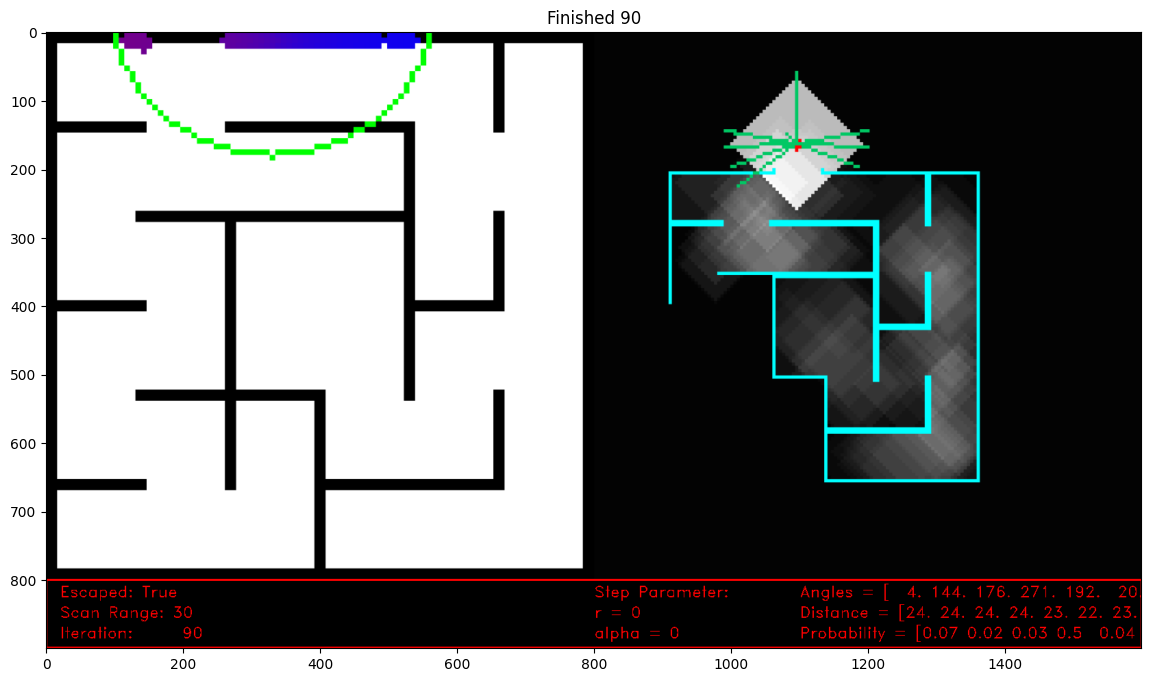

In [4]:
#Maze Selection

maze_idx = 19

maze_show= cv2.imread(f'01_Mazes/Maze_{maze_idx}.png')
maze_show[maze_show>100]=255
maze_show[maze_show<=100]=0
w_init,h_init,c = maze_show.shape
robot_position=np.array([int(w_init/2),int(h_init)/2],dtype=np.int64)



#Video Output
save=True
fps = 30
final_image = fps

image_out = np.zeros((900,1600,3),dtype=np.uint8)
w_video,h_video,c = image_out.shape

if save:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(f'maze_occ_exploration_maze_{maze_idx}.mp4', fourcc, fps, (h_video,w_video))

#Exploration Parameter
scan_range = 30
foot_size = 20
grad_size=2
boder_safety_distance = 5

record_movement = np.array([[0,0]])


#Map Initialization
maze_map = np.ones((2*scan_range+1,2*scan_range+1))

map_position = np.array([scan_range,scan_range])
map_origin = np.array([scan_range,scan_range])
#print(map_position)
init_action = np.array([0,0])

random_actions = np.array([
    [5,0],
    [-5,0],
    [0,5],
    [0,-5],
])


#Exploration
for iteration in range(20000):
    image_out = np.zeros((900,1600,3),dtype=np.uint8)
    
    escaped = check_escape(robot_position,maze_show)
    if not escaped:
        print_iter_out=iteration
    
    w_map,h_map = maze_map.shape
    if iteration==0:
        alpha = 0
        length = 0
        action = init_action
    elif escaped:
        alpha = 0
        length = 0
        action = init_action
    
    elif pos_angles.size!=0:
        #print(pos_angles[2,:])
        if pos_angles.shape[0]!=1:
            a = np.random.choice(np.arange(0,pos_angles.shape[1],1),p=pos_angles[2,:])
        else:
            a=0
        
        alpha = pos_angles[0,a]
        try:
            step_length = np.arange(1,pos_angles[1,a],3)
            length =np.random.choice(step_length)
        except:
            length = 1
        
        dx,dy = int(length*np.cos(alpha*np.pi/180)),int(length*np.sin(alpha*np.pi/180))
        action=np.array([dy,dx])
      
    
    elif (maze_show[robot_position[0],robot_position[1]]==0).all():
        print('On Wall')
        pos_angles=np.array([])
        idx = np.random.choice(np.arange(0,random_actions.shape[0],1))
        action = random_actions[idx]
    
    robot_position += action
    map_position += [action[1],action[0]]
    
    escaped = check_escape(robot_position,maze_show)
    if not escaped:
        record_movement = np.append(record_movement,np.copy(action).reshape((1,2)),axis=0) 
    
    
    if (0>(map_position[0]-scan_range))or(w_map<(map_position[0]+scan_range))or (0>(map_position[1]-scan_range))or(h_map<(map_position[1]+scan_range)):
        pad_y = [abs(min(0,action[0])),max(0,action[0])]
        pad_x = [abs(min(0,action[1])),max(0,action[1])]
        #print(pad_x,pad_y)
    else:
        pad_x = [0,0]
        pad_y = [0,0]
        
    map_position += [pad_x[0],pad_y[0]]    
    map_origin += [pad_x[0],pad_y[0]]    
    
    maze_map = np.pad(maze_map,(pad_x,pad_y),mode='constant',constant_values=1)
    
    
    if not escaped:
        On_track,_,_,dist,lidar,pos_angles = scan_standalone(robot_position,maze_show,scan_range=scan_range)
        #print(pos_angles)
        pos_angles = calaculate_step_occupancy(pos_angles,current_map=maze_map,current_position=map_position)
    
        try:
            for i in enumerate(dist):

                angle,distance = i
                x,y = map_position
                if distance!=-1:

                    dx,dy = int(distance*np.cos(angle*np.pi/180)),int(distance*np.sin(angle*np.pi/180))
                    #print(distance,y,y+dy,x+dx)
                    maze_map[x+dx,y+dy]=0
                    
        except TypeError:
            print(dist)
        
    maze_map = iterate_occupancy_grid_v3(current_map=maze_map,current_position=map_position,step_size=foot_size,grad_size=grad_size)
    
    
    #Visualizations for video output
    
    map_show = np.copy(maze_map)*(255/np.max(maze_map))
    
    
    w_scale,h_scale = map_show.shape
    pad_show_x,pad_show_y = abs(min(0,w_scale-h_scale)),max(0,w_scale-h_scale) 
    map_show = np.pad(map_show,((0,pad_show_x),(0,pad_show_y)),mode='constant',constant_values=np.uint8(255/2))
    
    
    map_show = cv2.cvtColor(map_show.astype(np.uint8),cv2.COLOR_GRAY2BGR)
    map_show[np.where(np.all(map_show==[0,0,0],axis=2))]=(255,255,0)

    
    cv2.circle(map_show,(map_position[1],map_position[0]),radius = 2,color = (0,0,255),thickness=-1)
    try:
        for idx in range(pos_angles.shape[1]):
            ang,d,p = pos_angles[:,idx]
            dy,dx = int((d-1)*np.cos(ang*np.pi/180)),int((d-1)*np.sin(ang*np.pi/180))
            sx,sy = map_position[1]+dx,map_position[0]+dy
            cv2.line(map_show,(map_position[1],map_position[0]),(sx,sy),color = (100,200,0),thickness=1)
    except:
        pass
    map_show=cv2.transpose(map_show)

    maze_position = np.copy(maze_show)
    cv2.circle(maze_position,(robot_position[1],robot_position[0]),radius = 3,color = (0,0,255),thickness=-1)
    cv2.circle(maze_position,(robot_position[1],robot_position[0]),radius = scan_range,color = (0,255,0),thickness=1)
    vis_scan(robot_position,dist,maze_position)
    
    maze_position=cv2.resize(maze_position,(800,800),interpolation = cv2.INTER_AREA)

    image_out[:800,:800,:]=maze_position
    image_out[:800,800:,:]=cv2.resize(map_show,(800,800),interpolation = cv2.INTER_AREA)
    
    cv2.rectangle(image_out,(0,800),(1599,899),color = (0,0,255),thickness=2)

    cv2.putText(
        img = image_out,
        text = f"Step Parameter:",
        org = (800,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"r = {int(length)}",
        org = (800,855),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"alpha = {alpha}",
        org = (800,885),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Angles = {pos_angles[0,:]}",
        org = (1100,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Distance = {pos_angles[1,:]}",
        org = (1100,855),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Probability = {np.around(pos_angles[2,:],decimals=2)}",
        org = (1100,885),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    
    cv2.putText(
        img = image_out,
        text = f"Escaped: {escaped}",
        org = (20,825),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Scan Range: {scan_range}",
        org = (20,855),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    cv2.putText(
        img = image_out,
        text = f"Iteration: {print_iter_out:7}",
        org = (20,885),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.75,
        color = (0,0,255),
        thickness = 1
    )
    
    cv2.imshow('Overview',image_out)
    
    if save: out.write(image_out)
    key = cv2.waitKey(1)
    
    if key==ord('q'):
        #End exploration
        break
        
    if key == ord('p'):
        #Pause
        cv2.waitKey()
        
    if escaped:
        final_image-=1
        
        if final_image==0:
            break

print(f'Escaped after {print_iter_out}')

plt.figure(figsize=(15,8))
plt.title(f'Finished {print_iter_out}')
plt.imshow(cv2.cvtColor(image_out,cv2.COLOR_BGR2RGB))
cv2.destroyAllWindows()
if save: out.release()

## 3. Wavefront + Path Finding

(2, 811)
(2, 100)
Image Output size: (507, 507)


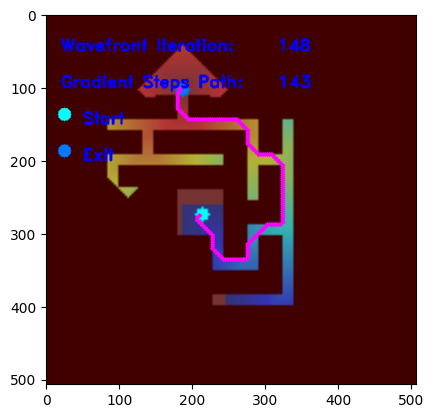

In [9]:
map_test = np.copy(maze_map)
map_test = extend_boders(map_test,thickness=9)



#map_cut,start,exit = cut_generated_map(np.copy(maze_map),map_origin,map_position)
map_cut,start,exit = np.copy(map_test),map_origin,map_position

#empty_map = np.copy(generated_map)
empty_map = np.copy(map_cut)
empty_map[empty_map==1]=0
empty_map[empty_map>=2]=1
cv_map_boders = np.copy(empty_map)
cv_map_boders[cv_map_boders==-1]=125
cv_map_boders[cv_map_boders==1]=255
cv_map_boders[cv_map_boders==0]=0

window_scaling = 3
steps=0


cv_map_boders = cv2.cvtColor(np.uint8(cv_map_boders),cv2.COLOR_GRAY2BGR)
cv2.circle(cv_map_boders,(start[1],start[0]),radius = 3,color = (0,0,255),thickness=-1)
cv2.circle(cv_map_boders,(exit[1],exit[0]),radius = 3,color = (0,0,255),thickness=-1)


empty_map[empty_map==2]=1
w_em,h_em = empty_map.shape

w_out,h_out = (w_em * window_scaling) ,(h_em * window_scaling)
print(f'Image Output size: {w_out,h_out}')
save=True
if save:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(f'maze_occ_escape_maze_{maze_idx}.mp4', fourcc, 60.0, (w_out,h_out))


moore_neighborhood = [
            [0,1],
            [1,0],
            [0,-1],
            [-1,0],
            [1,1],
            [-1,-1],
            [-1,1],
            [1,-1]
        ]

v_neumann_neighborhood = [
            [0,1],
            [1,0],
            [0,-1],
            [-1,0]
        ]

grad = [[exit[0],exit[1]]]

li=grad.copy()
iteration = 1
path_found = False
additional_steps=5
running =True
while running:
    #print(iteration)
    li=grad.copy()
    current_points = len(grad)
    for P in li:
        
        follow_points=0
        for i,j in moore_neighborhood:
                if not(i==0 and j==0):
                    if (0<=P[0]+i<w_em) and (0<=P[1]+j<h_em):
                        if ((P[0]+i==start[0]) and (P[1]+j==start[1])):
                            path_found = True

                        if empty_map[P[0]+i,P[1]+j]==1:
                            follow_points+=0.01
                            grad.append([P[0]+i,P[1]+j])

                            empty_map[P[0]+i,P[1]+j]+=iteration
    
    #Visualization
    cv_map_show = cv2.applyColorMap(np.uint8(empty_map*255/np.max(empty_map)), cv2.COLORMAP_JET)
    cv_map_show = cv2.addWeighted(cv_map_boders,0.2,cv_map_show,0.5,0)
    cv2.circle(cv_map_show,(start[1],start[0]),radius = 3,color = (0, 255, 255),thickness=-1)
    cv2.circle(cv_map_show,(exit[1],exit[0]),radius = 3,color = (0,120,255),thickness=-1)
    
    cv_map_show = cv2.resize(cv_map_show,(h_out,w_out))
    cv_map_show = cv2.transpose(cv_map_show)
    
    cv2.putText(
        img = cv_map_show,
        text = f"Wavefront Iteration: {iteration:7}",
        org = (20,50),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.25*window_scaling,
        color = (0,0,255),
        thickness = 2
    )
    cv2.putText(
        img = cv_map_show,
        text = f"Gradient Steps Path: {steps:6}",
        org = (20,100),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.25*window_scaling,
        color = (0,0,255),
        thickness = 2
    )

    cv2.circle(cv_map_show,(25,137),radius = 3*window_scaling,color = (0,255,255),thickness=-1)
    cv2.circle(cv_map_show,(25,187),radius = 3*window_scaling,color = (0,120,255),thickness=-1)

    cv2.putText(
        img = cv_map_show,
        text = f"Start",
        org = (50,150),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.25*window_scaling,
        color = (0,0,255),
        thickness = 2
    )
    cv2.putText(
        img = cv_map_show,
        text = f"Exit",
        org = (50,200),
        fontFace = cv2.FONT_HERSHEY_DUPLEX,
        fontScale = 0.25*window_scaling,
        color = (0,0,255),
        thickness = 2
    )
    
    
    cv2.imshow('Map',cv_map_show)
    #print(cv_map_show.shape)
    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break
    
    if path_found:
        additional_steps -=1
        if additional_steps==0:
            running=False
        #break
    
    
    for n in range(current_points):
        grad.pop(0)
    iteration+=1

 
#break in between
for i in range(120):
    cv2.imshow('Map',cv_map_show)
    #print(cv_map_show.shape)
    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break

visualize=True
    

running=True
step_back=start
shortest_path = []
global_distance = []
steps = 0
while running:
    cv_map_show = cv2.applyColorMap(np.uint8(empty_map*255/np.max(empty_map)), cv2.COLORMAP_JET)
    cv_map_show = cv2.addWeighted(cv_map_boders,0.2,cv_map_show,0.5,0)
    cv2.circle(cv_map_show,(start[1],start[0]),radius = 3,color = (0,255,255),thickness=-1)
    cv2.circle(cv_map_show,(exit[1],exit[0]),radius = 3,color = (0,120,255),thickness=-1)
    
    back = []
    gradient_min=[]
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            if steps ==0:
                if j==-1:
                    continue
                    
            if [exit[0],exit[1]]==[step_back[0]+i,step_back[1]+j]:
                #print('Finished')
                running=False
        
            #print(t)
            
            #vis_cut(empty_map,[step_back[0],step_back[1]],1)
            m = empty_map[step_back[0]+i,step_back[1]+j]
            if m >0:
                back.append([step_back[0]+i,step_back[1]+j])
            
                global_distance.append(m)
                gradient_min.append(m)

    idx = gradient_min.index(np.min(gradient_min))
    #print(idx)
    step_back = back[idx]
    shortest_path.append(step_back)
    steps+=1
    if visualize:
        cv_map_show = cv2.resize(cv_map_show,(h_out,w_out))
        cv_map_show = cv2.transpose(cv_map_show)
        for vis_point in shortest_path:
            cv2.circle(cv_map_show,(window_scaling*vis_point[0],window_scaling*vis_point[1]),radius = window_scaling,color =(255,0,255),thickness=-1)
        
        
        
        cv2.putText(
            img = cv_map_show,
            text = f"Wavefront Iteration: {iteration:7}",
            org = (20,50),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.25*window_scaling,
            color = (0,0,255),
            thickness = 2
        )
        cv2.putText(
            img = cv_map_show,
            text = f"Gradient Steps Path: {steps:6}",
            org = (20,100),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.25*window_scaling,
            color = (0,0,255),
            thickness = 2
        )
        
        cv2.circle(cv_map_show,(25,137),radius = 3*window_scaling,color = (0,255,255),thickness=-1)
        cv2.circle(cv_map_show,(25,187),radius = 3*window_scaling,color = (0,120,255),thickness=-1)

        cv2.putText(
            img = cv_map_show,
            text = f"Start",
            org = (50,150),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.25*window_scaling,
            color = (0,0,255),
            thickness = 2
        )
        cv2.putText(
            img = cv_map_show,
            text = f"Exit",
            org = (50,200),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.25*window_scaling,
            color = (0,0,255),
            thickness = 2
        )
        
        cv2.imshow('Map',cv_map_show)

        if save: out.write(cv_map_show)
        if cv2.waitKey(10)==ord('q'):
            break

            
for i in range(120):
    cv2.imshow('Map',cv_map_show)

    if save: out.write(cv_map_show)
    if cv2.waitKey(10)==ord('q'):
        break            

if save: out.release()
cv2.destroyAllWindows()

plt.imshow(cv_map_show)

## 4. Show Solution

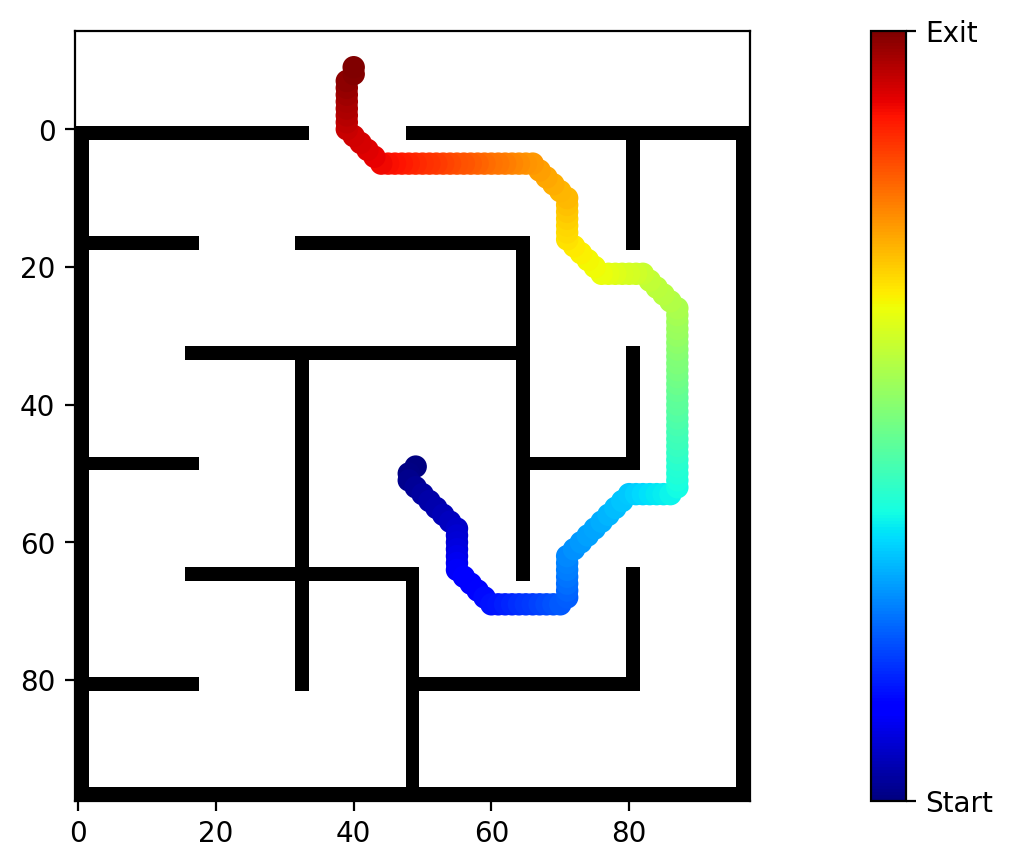

In [10]:
grid_plot = gs.GridSpec(1,2,width_ratios=[25,1],wspace=0.05)
fig = plt.figure(figsize=(6,5),dpi=200)

ax=fig.add_subplot(grid_plot[0])
bx=fig.add_subplot(grid_plot[1])
ax.imshow(maze_show)
s = np.array(shortest_path)
s=s-s[0,:]+[w_init/2,h_init/2]
scatter = ax.scatter(s[:,0],s[:,1],s=50,c=np.arange(0,s.shape[0],1),cmap='jet')
cbar = fig.colorbar(scatter,cax=bx,shrink=0.8)
cbar.set_ticks([0,s.shape[0]-1],labels = ['Start','Exit'])
#plt.axis([-25,347,347,-25])
fig.savefig(f'Maze_{maze_idx}.png')